**Thinking1: 奇异值分解SVD的原理是怎样的，都有哪些应用场景**

SVD的原理：
- 矩阵可以被分解为三个矩阵$A=P\Lambda Q^T$
- 奇异值较大部分对应矩阵中的主要部分。

应用：
- 保留不同数量的奇异值可以实现降维，例如图象压缩、评分预测（低维矩阵近似实现矩阵补全）

**Thinking2：funkSVD, BiasSVD，SVD++算法之间的区别是怎样的**

- FunkSVD：
  - $M_{m,n}=P^T_{k,m}Q_{k,n}$
  - 最小化损失函数：$\sum_{i,j}=(m_{ij}-q^T_j p_i)^2$
  - 防止过拟合也可以加上正则项
  - 用SGD进行求解，和ALS矩阵分解一样，只是求解方式不同
- BiasSVD：
  - 用户商品都有自己的偏好（bias）
  - $\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$
  - 优化目标：$\text{arg}\min\limits_{p_i,q_j}\sum_{i,j}(m_{ij}-\mu-b_i-b_j-q^T_j p_i)^2+\text{regularizations}$
  - 用SGD进行求解
- SVD++
  - 在BasicSVD基础上的改进：考虑用户的隐式反馈
  - 隐式反馈：没有具体的评分，可能是点击、浏览
  - $\hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)$
  - $ y_j:$代表隐式反馈的评分，这里指用户u对商品j进行了打分这一事实。

**Thinking3：矩阵分解算法在推荐系统中有哪些应用场景，存在哪些不足**

应用场景：
  1. 矩阵分解只考虑user和item特征，主要用于召回。
  2. 能将高维的矩阵映射成两个低维矩阵的乘积，很好地解决了数据稀疏的问题，在初期用户评分数据较少时可以采用。

不足：
  1. 隐语义虽然是个很好的想法，但可解释性差。
  2. 没有考虑动态信息，推荐不够精准。
  3. 更新信息（新用户、新商品、新评分）的加入需要重新进行矩阵分解，费时费力。

**Thinking4：假设一个小说网站，有N部小说，每部小说都有摘要描述。如何针对该网站制定基于内容的推荐系统，即用户看了某部小说后，推荐其他相关的小说。原理和步骤是怎样的**

1. 基于摘要描述进行特征提取
  - 进行分词，提取N个连续字集合作为特征
  - 按照TF-IDF筛选关键词，生成TF-IDF矩阵
2. 用TF-IDF向量计算小说之间的相似度
3. 相似度最高的K个小说作为推荐

**Thinking5：Word2Vec的应用场景有哪些**

- 在NLP中的应用：
  - 计算相似度（寻找相似词、信息检索）
  - 作为时间序列模型的输入（智能聊天机器人）
  - 句子表示（情感分析）
  - 文档表示（文档主题判别）
- 在推荐系统中的应用：
  - 商品看作词，用户购买序列看作文档
  - 相似词对应于相似商品
  - 时间序列分析，预测下一个词对应于预测下一个商品
  - 文档主题判别对应于用户喜好商品的类别判定， 基于类别推荐相应商品

**Action1:选择任意一张图片，对其进行灰度化，然后使用SVD进行图像的重构，当奇异值数量为原有的1%，10%，50%时，输出重构后的图像**

In [23]:
import numpy as np
from PIL import Image
from scipy.linalg import svd
import matplotlib.pyplot as plt

In [33]:
img = np.array(Image.open('rome.jpg').convert('L'))

In [41]:
U, s, Vh = svd(img, full_matrices=False)

In [48]:
def image_compress(scale):
    # 特征数
    k = round(scales[i]*len(s))
    # 提取前k个特征
    s_k = np.zeros(s.shape)
    s_k[:k] = s[:k]
    s_k = s_k*np.identity(len(s))
    # 重构图片
    img_k = np.dot(np.dot(U, s_k), Vh)
    # 显示图片
    plt.imshow(img_k, cmap=plt.cm.gray, interpolation='nearest')
    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

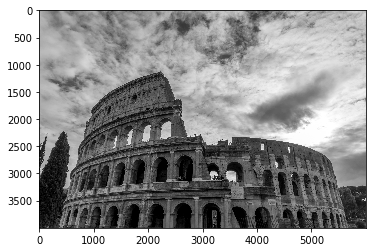

In [53]:
# 显示原图
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
plt.show

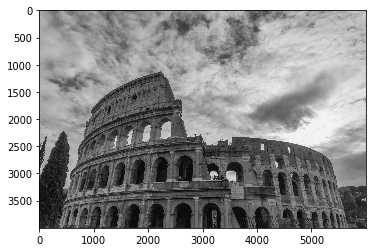

In [49]:
# 1%的奇异值
image_compress(0.01)

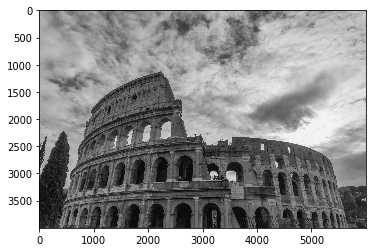

In [51]:
# 10%的奇异值
image_compress(0.1)

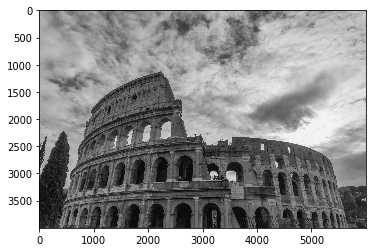

In [52]:
# 50%的奇异值
image_compress(0.5)

**可以看到只用1%的奇异值效果也不错，说明大的奇异值很好地保留了图片的特征**

**Action2：使用Google Colab编辑器，对MovieLens数据集进行评分预测，计算RMSE（使用funkSVD, BiasSVD，SVD++）**

In [9]:
#!pip install surprise
from surprise import SVD, SVDpp
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
import pandas as pd
import time


from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/")

time1=time.time()

# 数据读取
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('../ratings.csv', reader=reader)
train_set = data.build_full_trainset()

time2=time.time()
print(f"数据读取时间：{time2-time1}")


# 使用funkSVD
# 定义K折交叉验证迭代器，K=3
kf = KFold(n_splits=3)
# 存储K个模型
algos = []
for trainset, testset in kf.split(data):
    # 低维矩阵维度100，迭代次数20
    algo = SVD(biased=False)
    # 训练并预测
    algo.fit(trainset)
    predictions = algo.test(testset)
    # 计算RMSE
    accuracy.rmse(predictions, verbose=True)
    # 存储该模型
    algos.append(algo)

uid = str(196)
iid = str(302)
# 输出uid对iid的预测结果
preds = [algo.predict(uid, iid, r_ui=4, verbose=True).est for algo in algos]
print('K-fold mean predictions of FunkSVD:', sum(preds)/len(preds))
time3=time.time()
print(f"FunkSVD time:{time3-time2}")


# 使用BiasSVD
# 定义K折交叉验证迭代器，K=3
kf = KFold(n_splits=3)
# 存储K个模型
algos = []
for trainset, testset in kf.split(data):
    algo = SVD(biased=True)
    # 训练并预测
    algo.fit(trainset)
    predictions = algo.test(testset)
    # 计算RMSE
    accuracy.rmse(predictions, verbose=True)
    # 存储该模型
    algos.append(algo)

uid = str(196)
iid = str(302)
# 输出uid对iid的预测结果
preds = [algo.predict(uid, iid, r_ui=4, verbose=True).est for algo in algos]
print('K-fold mean predictions of BiasSVD:', sum(preds)/len(preds))
time4=time.time()
print(f"BiasSVD time:{time4-time3}")


# 使用SVD++
# 定义K折交叉验证迭代器，K=3
kf = KFold(n_splits=3)
# 存储K个模型
algos = []
for trainset, testset in kf.split(data):
    algo = SVDpp()
    # 训练并预测
    algo.fit(trainset)
    predictions = algo.test(testset)
    # 计算RMSE
    accuracy.rmse(predictions, verbose=True)
    # 存储该模型
    algos.append(algo)

uid = str(196)
iid = str(302)
# 输出uid对iid的预测结果
preds = [algo.predict(uid, iid, r_ui=4, verbose=True).est for algo in algos]
print('K-fold mean predictions of SVD++:', sum(preds)/len(preds))
time5=time.time()
print(f"SVD++ time:{time5-time4}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
数据读取时间：3.3670263290405273
RMSE: 0.8706
RMSE: 0.8730
RMSE: 0.8743
user: 196        item: 302        r_ui = 4.00   est = 3.79   {'was_impossible': False}
user: 196        item: 302        r_ui = 4.00   est = 4.52   {'was_impossible': False}
user: 196        item: 302        r_ui = 4.00   est = 3.89   {'was_impossible': False}
K-fold mean predictions of FunkSVD: 4.0659913226547735
FunkSVD time:150.83818745613098
RMSE: 0.8455
RMSE: 0.8458
RMSE: 0.8450
user: 196        item: 302        r_ui = 4.00   est = 4.13   {'was_impossible': False}
user: 196        item: 302        r_ui = 4.00   est = 4.03   {'was_impossible': False}
user: 196        item: 302        r_ui = 4.00   est = 4.39   {'was_impossible': False}
K-fold mean predictions of BiasSVD: 4.181323839109293
BiasSVD time:152.7379596233368
RMSE: 0.8300
RMSE: 0.8292
RMSE: 0.8289
user: 196        item: 302        

- **SVD++确实能够降低RMSE，但运行时间显著增加。**  
- **surprise的SVDpp函数默认n_factors=20, 而SVD函数默认n_factors=100，在n_factors是1/5的情况下，运算时间多了60倍，说明SVD++时间复杂度高很多。**  
- **从原理上看SVD++和SVD都采用SGD方法迭代求解，不同只在于SVD++在损失函数上多考虑了用户打分这一动作引入的隐式评分$y_j$, 这里$y_j$和商品矩阵维度一样，也是需要训练的，这就造成时间花费大大增加。**  
- **SVDpp函数源码中也提到计算$y_j$非常花费时间：**  

>         # items rated by u. This is **COSTLY**  
        Iu = [j for (j, _) in trainset.ur[u]]  
        sqrt_Iu = np.sqrt(len(Iu)) 
        # compute user implicit feedback
        u_impl_fdb = np.zeros(self.n_factors, np.double)
        for j in Iu:
            for f in range(self.n_factors):
                u_impl_fdb[f] += yj[j, f] / sqrt_Iu
              

**Action3:使用Gensim中的Word2Vec对三国演义进行Word Embedding，分析和曹操最相近的词有哪些，曹操+刘备-张飞=?
数据集：three_kingdoms.txt**

***jieba进行分词***

In [4]:
import jieba
import os

# 源文件所在目录
path = './L5-code/word2vec'
source_folder = path+'/three_kingdoms/source'
segment_folder = path+'/three_kingdoms/segment'

In [8]:
# 字词分割，对整个文件内容进行字词分割
def segment_lines(file_list,segment_out_dir,stopwords=[]):
    for i,file in enumerate(file_list):
        segment_out_name=os.path.join(segment_out_dir,'segment_{}.txt'.format(i))
        with open(file, 'rb') as f:
            document = f.read()
            document_cut = jieba.cut(document)
            sentence_segment=[]
            for word in document_cut:
                if word not in stopwords:
                    sentence_segment.append(word)
            result = ' '.join(sentence_segment)
            result = result.encode('utf-8')
            with open(segment_out_name, 'wb') as f2:
                f2.write(result)

# 对source中的txt文件进行分词，输出到segment目录中
file_list=[source_folder+'/three_kingdoms.txt']
segment_lines(file_list, segment_folder)


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\luoyh\AppData\Local\Temp\jieba.cache
Loading model cost 1.329 seconds.
Prefix dict has been built succesfully.


***训练word2vec模型***

In [9]:
# -*-coding: utf-8 -*-
# 先运行 word_seg进行中文分词，然后再进行word_similarity计算
# 将Word转换成Vec，然后计算相似度 
from gensim.models import word2vec
import multiprocessing

# 如果目录中有多个文件，可以使用PathLineSentences
sentences = word2vec.PathLineSentences(segment_folder)

# 设置模型参数，进行训练
model2 = word2vec.Word2Vec(sentences, size=256, window=10, min_count=5, workers=multiprocessing.cpu_count())
# 保存模型
model2.save(path+'/models/word2Vec_threekingdoms.model')
print(model.wv.most_similar(positive=['曹操']))
print(model.wv.most_similar(positive=['曹操', '刘备'], negative=['张飞']))


[('孔明', 0.995713472366333), ('周瑜', 0.9924947023391724), ('已', 0.9924814105033875), ('关公', 0.9924523830413818), ('李乐', 0.9900927543640137), ('他', 0.9899201989173889), ('孙权', 0.9895942211151123), ('夫人', 0.9895313382148743), ('拜', 0.98792564868927), ('张飞', 0.9877635836601257)]
[('某', 0.9944369792938232), ('荀彧', 0.9943516850471497), ('商议', 0.9932315945625305), ('丞相', 0.9930415749549866), ('既', 0.9929061532020569), ('臣', 0.992876410484314), ('家兄', 0.9926998615264893), ('今', 0.9924429655075073), ('主公', 0.9921380281448364), ('谏', 0.9921252727508545)]
